In [1]:
import pandas as pd
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

In [2]:
backbone = 'resnet18'
pretrained_weight = '/workdir/dataset/checkpoints/casiafull_sgd_2019-05-05_02-32-33/resnet18_30.pth'
lfw_txt_path = '/workdir/lfw_test_pair.txt'
lfw_root = '/workdir/dataset/lfw-deepfunneled/'
input_shape = (3, 200, 200)
use_gpu = True

In [3]:
import torch
from models.resnet import get_model
from torchvision import transforms

In [4]:
model = get_model(backbone)()
model.load_state_dict(torch.load(pretrained_weight))
model.eval()

if use_gpu:
    device = torch.device('cuda')
    model.to(device)

In [5]:
test_transformer = transforms.Compose([
    transforms.Resize(size=(350, 350)),
    transforms.CenterCrop(size=input_shape[1:]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [6]:
df_test = pd.read_csv(lfw_txt_path, sep=' ', header=None)
df_test.columns = ['left_img', 'right_img', 'target']

In [7]:
use_images = set(df_test['left_img']) | set(df_test['right_img'])

In [8]:
len(use_images)

7701

In [9]:
from collections import OrderedDict

In [10]:
name2embedding = OrderedDict()

In [11]:
for p in use_images:
    break

In [12]:
img_path = os.path.join(lfw_root, p)

In [13]:
img = Image.open(img_path)

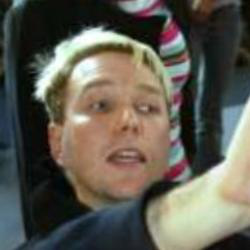

In [14]:
img

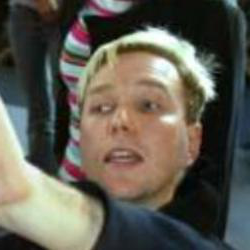

In [15]:
ImageOps.mirror(img)

In [16]:
def img_to_feature(img):
    data = torch.zeros([2, *input_shape])
    data[0] = test_transformer(img)
    data[1] = test_transformer(ImageOps.mirror(img))
    data = data.to(device)
    output = model(data)
    return output.data.cpu().numpy().reshape(-1)

In [17]:
embedding_feat = img_to_feature(img)

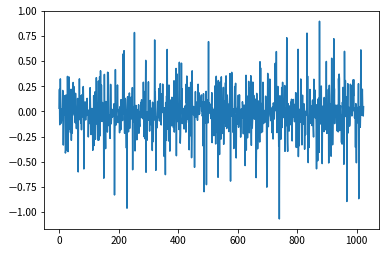

In [18]:
plt.plot(embedding_feat)

In [19]:
from tqdm import tqdm_notebook as tqdm

In [20]:
for p in tqdm(use_images, total=len(use_images)):
    img_path_i = os.path.join(lfw_root, p)
    img_i = Image.open(img_path_i)
    embedding_i = img_to_feature(img_i)
    name2embedding[p] = embedding_i

メタデータにあるペア同士のコサイン類似度を計算していく

In [21]:
similarities = []

In [22]:
from scipy.spatial.distance import cosine

In [23]:
'Gillian_Anderson/Gillian_Anderson_0002.jpg' in use_images

True

In [24]:
for i, row in df_test.iterrows():
    try:
        x, y = name2embedding[row.left_img], name2embedding[row.right_img]
    except KeyError as e:
        print(e)
        continue
    similarities.append(1 - cosine(x, y))

In [25]:
df_eval = pd.DataFrame()

In [26]:
df_eval['target'] = df_test.target

In [27]:
df_eval['pred'] = similarities

In [28]:
import seaborn as sns

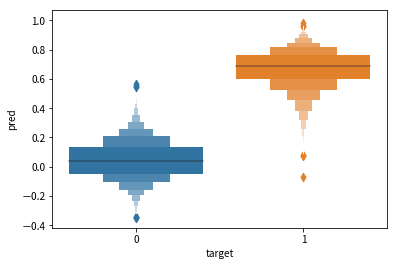

In [29]:
sns.boxenplot(data=df_eval, x='target', y='pred')

In [30]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
import numpy as np

In [31]:
roc_auc_score(df_eval.target, df_eval.pred)

0.9976381111111112

In [32]:
thresholds = np.linspace(-1, 1, 1000)

In [33]:
use_metrics = [
    accuracy_score,
    f1_score,
    recall_score,
    precision_score
]

In [34]:
def calc_metrics(y_true, y_pred):
    m = [f(y_true, y_pred) for f in use_metrics]
    return m

In [35]:
data = []
for t in thresholds:
    pred_label = np.where(df_eval.pred > t, 1, 0)
    data.append(calc_metrics(df_eval.target, pred_label))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
df_metric = pd.DataFrame(data, columns=[f.__name__ for f in use_metrics])

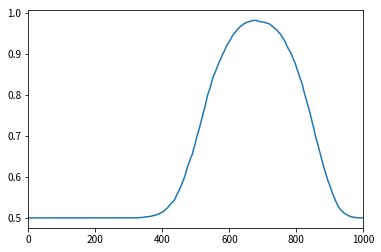

In [37]:
df_metric.accuracy_score.plot()

In [38]:
df_metric.max()

accuracy_score     0.982333
f1_score           0.982251
recall_score       1.000000
precision_score    1.000000
dtype: float64